In [1]:
import torch
from torch import nn
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
from copy import deepcopy

In [2]:
class MyModel(nn.Module):
    def __init__(self, all_sizes, activation=nn.ReLU):
        super(MyModel, self).__init__()

        input_size, *hidden_sizes, output_size = all_sizes

        layers = []
        current_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(activation())
            current_size = hidden_size

        layers.append(nn.Linear(current_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [3]:
sizes = [10, 20, 40, 20, 1]
model = MyModel(sizes)
print(model)

X, y = make_regression(n_samples=1000, n_features=sizes[0], n_informative=sizes[0], random_state=42)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

dataset = list(zip(X, y))
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

criterion = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyModel(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)


MyModel(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

# Sparse Linear

In [4]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt


class SparseLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(SparseLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.weight = nn.Parameter(torch.randn(out_features, in_features).to_sparse())

        if bias:
            self.bias = nn.Parameter(torch.randn(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, input):
        output = torch.sparse.mm(self.weight, input.t()).t()
        if self.bias is not None:
            output += self.bias
        return output

def convert_sparse_weights_to_dense(model):
    for module in model.modules():
        if isinstance(module, SparseLinear):
            module.weight = nn.Parameter(module.weight.to_dense()) 

def convert_dense_weights_to_sparse(model):
    for module in model.modules():
        if isinstance(module, SparseLinear):
            module.weight = nn.Parameter(module.weight.to_sparse()) 


# Train

In [5]:
def valid_model(model, valid_loader, criterion):
    model.eval()
    mse = 0
    with torch.no_grad():
        for data in valid_loader:
            x, y = data
            x, y = x.to(device), y.to(device)
            output = model(x).view(-1)
            mse += criterion(output, y)
    return mse / len(valid_loader)

In [6]:
def train_one_model(model, train_loader, valid_loader, epochs=10000, patience=10, min_delta=1e-4, criterion=torch.nn.L1Loss()):
    optimizer = torch.optim.AdamW(model.parameters(), lr=4e-3)
    best_loss = float('inf')
    epochs_no_improve = 0
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()

        convert_sparse_weights_to_dense(model)

        for data in train_loader:
            x, y = data
            x, y = x.to(device), y.to(device)
            x = x.to_dense() if x.is_sparse else x
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.view(-1), y)
            loss.backward()

            optimizer.step()

        convert_dense_weights_to_sparse(model)

        val_loss = valid_model(model, valid_loader, criterion)
        val_losses.append(val_loss.item())

        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

    plt.figure(figsize=(10, 5))
    plt.plot(val_losses, label="Validation Loss")
    plt.axhline(y=sum(val_losses) / len(val_losses), color='r', linestyle='--', label="Average Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Validation Loss per Epoch")
    plt.legend()
    plt.show()

    return best_loss

Training Progress:   2%|▏         | 153/10000 [00:07<08:34, 19.15it/s]


Early stopping triggered


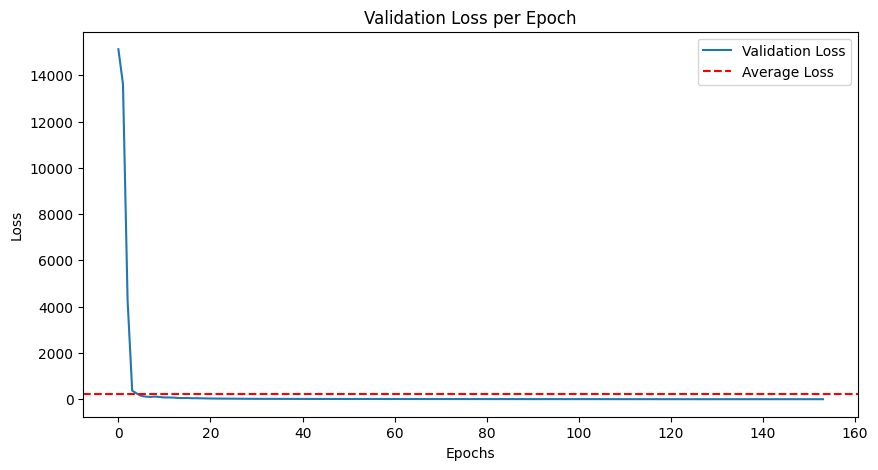

tensor(1.3617)

In [7]:
train_one_model(model, train_loader, test_loader, criterion=criterion)

In [8]:

valid_model(model, test_loader, criterion)


tensor(1.9742)

# Pruning

In [9]:
@torch.enable_grad()
def evaluate_sensitivity(model, dataloader, loss_function, eps=1e-10):
    sensitivity = {}
    model.to(device)
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        model.zero_grad()
        output = model(data).squeeze(dim=-1)
        loss = loss_function(output, target)
        loss.backward()

        for param_name, param in model.named_parameters():
            if "weight" in param_name:
                if param_name in sensitivity:
                    sensitivity[param_name] += param.grad.abs()
                else:
                    sensitivity[param_name] = param.grad.abs()

    for k, sens_tensor in sensitivity.items():
        sensitivity[k] = sens_tensor / torch.max(sens_tensor.max(), torch.tensor(eps, device=sens_tensor.device))

    return sensitivity


In [10]:
def do_pruning(model, pruning_type="Random", **kwargs):
    prune_model = deepcopy(model)

    amount = kwargs.get('amount', 0.3)
    logs = kwargs.get('logs', False)
    sensitivity = kwargs.get('sensitivity', {})
    counter = list(sensitivity.keys())

    def apply_l1_pruning(module):
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            if logs:
                print(f"Применен L1 прунинг к слою: {module}")
                print(f"Маска:\n{module.weight_mask}\n")

    def apply_random_pruning(module):
        if isinstance(module, nn.Linear):
            prune.random_unstructured(module, name='weight', amount=amount)
            if logs:
                print(f"Применен Random прунинг к слою: {module}")
                print(f"Маска:\n{module.weight_mask}\n")

    def remove_pruning(module):
        if isinstance(module, nn.Linear) and hasattr(module, 'weight_mask'):
            prune.remove(module, 'weight')
            if logs:
                print(f"Удалена маска прунинга в слое: {module}")

    def zero_weights_by_mask(module):
        if isinstance(module, nn.Linear) and hasattr(module, 'weight_mask'):
            with torch.no_grad():
                module.weight.data *= module.weight_mask
                if logs:
                    print(f"Обнулены веса по маске в слое: {module}")
                    print(f"Текущие веса:\n{module.weight.data}\n")

    def apply_sensitivity_pruning(module):
        nonlocal counter

        if isinstance(module, nn.Linear):
            param_name = counter.pop(0)
            if param_name in sensitivity:
                sens_tensor = sensitivity[param_name]

                flat_weights = module.weight.view(-1)
                flat_sensitivity = sens_tensor.view(-1)

                num_params_to_prune = int(amount * flat_sensitivity.numel())
                _, indices = torch.topk(flat_sensitivity, k=num_params_to_prune, largest=False)

                mask = torch.ones_like(flat_weights)
                mask[indices] = 0

                prune.custom_from_mask(module, name='weight', mask=mask.view_as(module.weight))

                if logs:
                    print(f"Применен Sensitivity-based прунинг к слою: {module}")
                    print(f"Маска:\n{mask.view_as(module.weight)}\n")

    pruning_funcs = {
        "L1": apply_l1_pruning,
        "Random": apply_random_pruning,
        "Remove": remove_pruning,
        "SensitivityBased": apply_sensitivity_pruning
    }
    apply_func = pruning_funcs.get(pruning_type)

    if apply_func:
        prune_model.apply(apply_func)
        prune_model.apply(zero_weights_by_mask)
        prune_model.apply(remove_pruning)

    return prune_model


In [11]:
sensitivity = evaluate_sensitivity(model, test_loader, criterion)
pruned_model = do_pruning(model, pruning_type="SensitivityBased", sensitivity=sensitivity, amount=0.2, logs=False)
pruned_model.to(device)

MyModel(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [12]:
# list(model.parameters())

In [13]:
# list(pruned_model.parameters())

In [14]:
valid_model(pruned_model, test_loader, criterion)

tensor(931.7150)

# Sparse

In [15]:
def convert_to_sparse(model):

    def convert_layer(layer):
        if isinstance(layer, nn.Linear):
            sparse_layer = SparseLinear(layer.in_features, layer.out_features, bias=layer.bias is not None)
            sparse_layer.weight = nn.Parameter(layer.weight.to_sparse())
            if layer.bias is not None:
                sparse_layer.bias = nn.Parameter(layer.bias)
            return sparse_layer
        else:
            return layer

    for name, module in model.named_children():
        if isinstance(module, nn.Sequential):
            for idx, layer in enumerate(module):
                module[idx] = convert_layer(layer)
        else:
            setattr(model, name, convert_layer(module))

    return model

In [16]:
sparse_model = convert_to_sparse(pruned_model)

In [17]:
# list(sparse_model.parameters())

In [18]:
valid_model(sparse_model, test_loader, criterion)

tensor(931.7150)

# Train more

Training Progress:   3%|▎         | 328/10000 [00:17<08:41, 18.56it/s]


Early stopping triggered


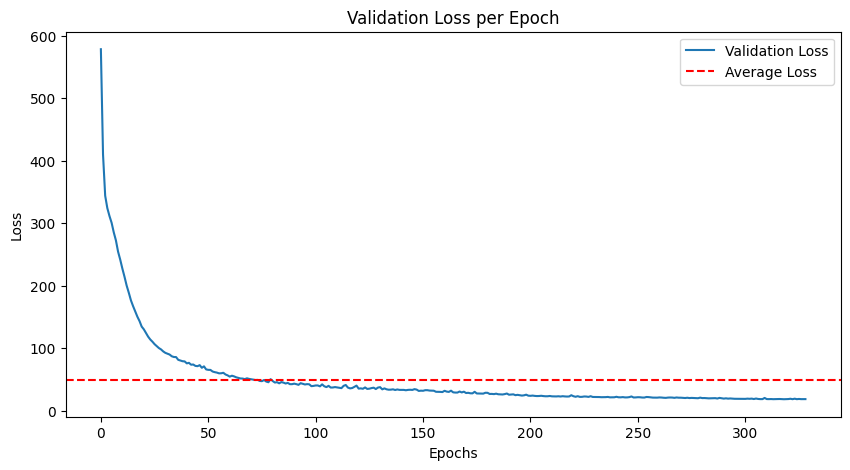

tensor(18.3528)

In [19]:
train_one_model(sparse_model, train_loader, test_loader, criterion=criterion)

In [20]:
valid_model(sparse_model, test_loader, criterion)

tensor(18.5178)

In [21]:
# list(sparse_model.parameters())